In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import h5py
from scipy.optimize import minimize

In [4]:
# Load AR results
precomputed_data = h5py.File("/mnt/home/sroy1/ar_lnm1_q_summary.hdf","r")
m1s = precomputed_data['posterior/m1s'][()]
dR_dlnm1s = precomputed_data['posterior/dR_dlnm1s'][()]

<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1281318/364225548.py:57: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(masses, dndm, lw=2, label=f"$\sigma$ = {val*34:.2f} $M_{{\\odot}}$")


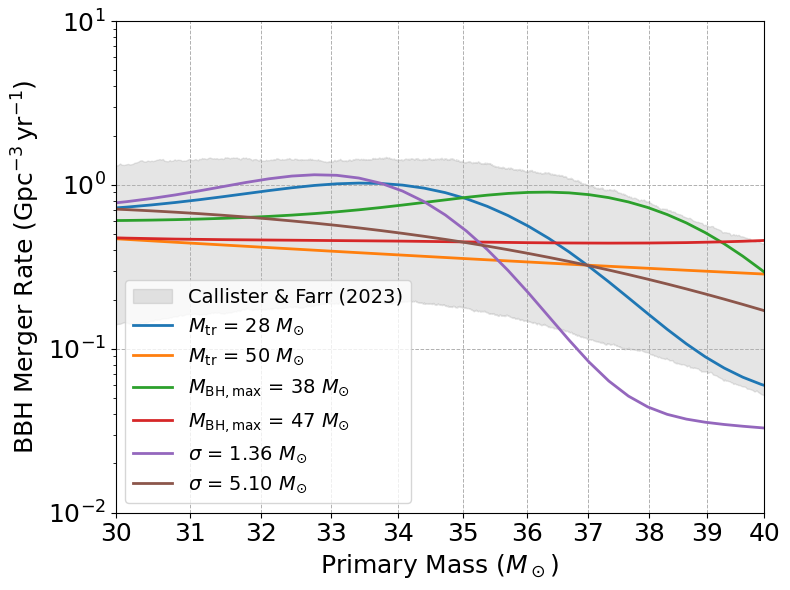

In [5]:
import numpy as np
import json
import matplotlib.pyplot as plt

# Load your JSON file
with open("mass_spec_all_variations.json", "r") as f:
    data = json.load(f)

masses = np.array(data["masses"])
vary_mpisn = data["vary_mpisn"]
vary_mbhmax = data["vary_mbhmax"]
vary_sigma = data["vary_sigma"]
vary_fpl = data["vary_fpl"]

# Assume you already have these:
# m1s: mass grid for your AR samples
# dR_dlnm1s: AR posterior samples

fig, ax = plt.subplots(figsize=(8,6))
ax.set_rasterization_zorder(2)

# Plot the 90% credible interval band
lower = np.percentile(dR_dlnm1s/m1s[:,None], 5, axis=1)
upper = np.percentile(dR_dlnm1s/m1s[:,None], 95, axis=1)

ax.fill_between(m1s, lower, upper, color='gray', alpha=0.2, label='Callister & Farr (2023)')

# --- Now add extremes from each model ---
mpisn_vals = sorted(set(entry["mpisn"] for entry in vary_mpisn))
mbhmax_vals = sorted(set(entry["mbhmax"] for entry in vary_mbhmax))
sigma_vals = sorted(set(entry["sigma"] for entry in vary_sigma))
fpl_vals = sorted(set(entry["fpl"] for entry in vary_fpl))

extremes = {
    "mpisn": [mpisn_vals[0], mpisn_vals[-1]],
    "mbhmax": [mbhmax_vals[0], mbhmax_vals[-1]],
    "sigma": [sigma_vals[0], sigma_vals[-1]],
    "fpl": [fpl_vals[0], fpl_vals[-1]],
}

# Plot mpisn extremes
for val in extremes["mpisn"]:
    entry = next(e for e in vary_mpisn if e["mpisn"] == val)
    dndm = np.array(entry["dndm"])
    ax.plot(masses, dndm, lw=2, label=f"$M_{{\\rm tr}}$ = {val} $M_{{\\odot}}$")

# Plot mbhmax extremes
for val in extremes["mbhmax"]:
    entry = next(e for e in vary_mbhmax if e["mbhmax"] == val)
    dndm = np.array(entry["dndm"])
    ax.plot(masses, dndm, lw=2, label=f"$M_{{\\rm BH,max}}$ = {val} $M_{{\\odot}}$")

# Plot sigma extremes
for val in extremes["sigma"]:
    entry = next(e for e in vary_sigma if e["sigma"] == val)
    dndm = np.array(entry["dndm"])
    ax.plot(masses, dndm, lw=2, label=f"$\sigma$ = {val*34:.2f} $M_{{\\odot}}$")

# Formatting
fontsize = 18
legend_fontsize = 14

ax.tick_params(labelsize=fontsize)
ax.set_xlim(30,40)
ax.set_ylim(1e-2, 1e1)
ax.set_xscale('log')
ax.set_yscale('log')

# Set x-ticks at 1 interval between 30 and 40
ax.set_xticks(np.arange(30, 41, 1))
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.grid(True, axis='x', linestyle='--', linewidth=0.7)
ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

ax.set_xlabel('Primary Mass ($M_\\odot$)', fontsize=fontsize)
ax.set_ylabel('BBH Merger Rate ($\\mathrm{Gpc}^{-3}\\,\\mathrm{yr}^{-1}$)', fontsize=fontsize)
ax.legend(fontsize=legend_fontsize)

plt.tight_layout()
plt.savefig('/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/match_ar1.pdf',bbox_inches='tight',dpi=200)